## Agregação por distrito

Nesse notebook é feita a agregação dos dados por distritos do município

In [1]:
import geopandas as gpd
import random
from shapely.geometry import LineString
from utils.save_shp import save_shp
from utils.load_csv import load_csv
from utils.load_shp import load_shp

In [2]:
gdf_final = load_csv("gdf_final.csv")

distritos = load_shp("distritos.shp")

In [3]:
gdf_final["lon"] = gdf_final["ponto_inicial"].apply(lambda x: eval(x)[0])
gdf_final["lat"] = gdf_final["ponto_inicial"].apply(lambda x: eval(x)[1])

In [4]:
gdf_final = gpd.GeoDataFrame(gdf_final, geometry=gpd.points_from_xy(gdf_final.lon, gdf_final.lat), crs="EPSG:31983")

In [5]:
gdf_final.head()

,id_onibus,linha,is_eletrico,distancia_percorrida,ponto_inicial,ponto_final,momento_inicial,momento_final,modelo,litro_diesel_km,emissao_no2,emissao_co2,lon,lat,geometry
0,11897,917H-10,False,10.601070,"[323730.2736653163, 7401579.57348449]","[np.float64(323723.320928209), np.float64(7401...",2025-09-23 10:19:04-03:00,2025-09-23 10:19:48-03:00,Padron,0.63,0.244713,0.406477,323730.273665,7.401580e+06,POINT (323730.274 7401579.573)
1,11897,917H-10,False,62.279468,"[323723.320928209, 7401571.570852276]","[np.float64(323763.6651873907), np.float64(740...",2025-09-23 10:19:48-03:00,2025-09-23 10:22:45-03:00,Padron,0.63,1.437645,2.387981,323723.320928,7.401572e+06,POINT (323723.321 7401571.571)
2,11897,917H-10,False,0.000000,"[323763.6651873907, 7401619.016325403]","[np.float64(323763.6651873907), np.float64(740...",2025-09-23 10:22:45-03:00,2025-09-23 10:23:30-03:00,Padron,0.63,0.000000,0.000000,323763.665187,7.401619e+06,POINT (323763.665 7401619.016)
3,11897,917H-10,False,0.000000,"[323763.6651873907, 7401619.016325403]","[np.float64(323763.6651873907), np.float64(740...",2025-09-23 10:23:30-03:00,2025-09-23 10:24:14-03:00,Padron,0.63,0.000000,0.000000,323763.665187,7.401619e+06,POINT (323763.665 7401619.016)
4,11897,917H-10,False,51.679120,"[323763.6651873907, 7401619.016325403]","[np.float64(323730.2736653163), np.float64(740...",2025-09-23 10:24:14-03:00,2025-09-23 10:24:58-03:00,Padron,0.63,1.192949,1.981532,323763.665187,7.401619e+06,POINT (323763.665 7401619.016)


In [6]:
dropar = gdf_final['id_onibus'].value_counts()[(gdf_final['id_onibus'].value_counts() == 1)].index

gdf_final = gdf_final[~gdf_final['id_onibus'].isin(dropar)].reset_index(drop=True)

In [7]:
trajetos = gdf_final.groupby("id_onibus")["geometry"].apply(lambda x: LineString(x.tolist()))
trajetos = gpd.GeoDataFrame(trajetos, geometry="geometry", crs="EPSG:31983").reset_index()

In [8]:
trajetos.head()

,id_onibus,geometry
0,2104,"LINESTRING (340262.649 7394996.041, 340226.538..."
1,3117,"LINESTRING (335833.601 7395023.115, 351848.612..."
2,7316,"LINESTRING (317964.902 7374418.635, 317964.902..."
3,10003,"LINESTRING (325264.024 7401668.077, 325264.024..."
4,10004,"LINESTRING (325823.862 7399386.457, 325774.368..."


In [9]:
agregados = gdf_final.groupby("id_onibus").agg({
    "emissao_co2": "sum",
    'is_eletrico': 'first'      
}).reset_index()

trajetos = trajetos.merge(agregados, on="id_onibus", how="left")

In [10]:
trajetos

,id_onibus,geometry,emissao_co2,is_eletrico
0,2104,"LINESTRING (340262.649 7394996.041, 340226.538...",75.191416,True
1,3117,"LINESTRING (335833.601 7395023.115, 351848.612...",2263.189229,True
2,7316,"LINESTRING (317964.902 7374418.635, 317964.902...",2.722655,True
3,10003,"LINESTRING (325264.024 7401668.077, 325264.024...",0.000000,False
4,10004,"LINESTRING (325823.862 7399386.457, 325774.368...",86.612420,True
...,...,...,...,...
10692,86517,"LINESTRING (325820.361 7383471.43, 325820.361 ...",0.612648,True
10693,86521,"LINESTRING (325976.942 7383610.919, 325976.942...",0.000000,True
10694,86522,"LINESTRING (320954.153 7390376.437, 321060.583...",70.117235,True
10695,86605,"LINESTRING (323723.549 7386359.448, 323723.549...",0.000000,False


<Axes: >

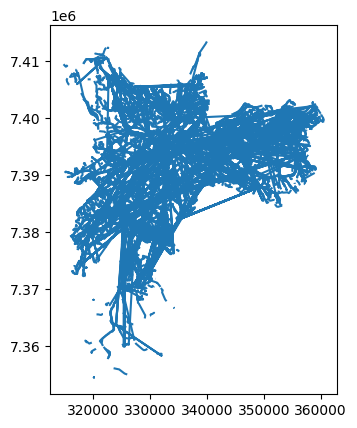

In [11]:
trajetos.plot()

21038


<Axes: >

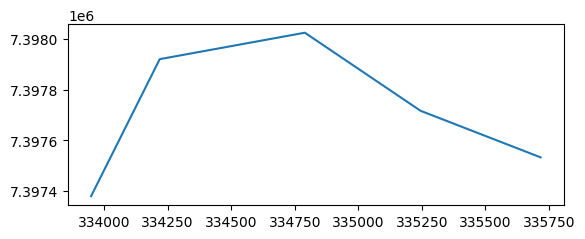

In [12]:
onibus_aleatorio = random.choice(trajetos['id_onibus'].unique().tolist())

print(onibus_aleatorio)
trajetos[trajetos['id_onibus'] == onibus_aleatorio].plot()

<Axes: >

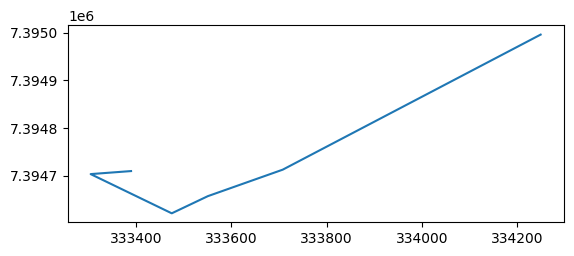

In [22]:
trajetos[trajetos['id_onibus'] == 41101].plot()

In [14]:
trajetos = trajetos.to_crs(distritos.crs)

In [15]:
trajetos_distritos = gpd.sjoin(trajetos, distritos, how="inner", predicate="intersects")

trajetos_distritos

,id_onibus,geometry,emissao_co2,is_eletrico,index_right,cd_identif,cd_identi0,cd_distrit,nm_distrit,sg_distrit,tx_escala,sg_fonte_o,dt_criacao,dt_atualiz,cd_usuario,cd_tipo_di,qt_area_qu,qt_area_me
0,2104,"LINESTRING (340262.649 7394996.041, 340226.538...",75.191416,True,46,8583424.0,25.0,80,TATUAPE,TAT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,8.514,8514313.05
1,3117,"LINESTRING (335833.601 7395023.115, 351848.612...",2263.189229,True,47,8583429.0,26.0,85,VILA FORMOSA,VFO,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,7.473,7473222.27
1,3117,"LINESTRING (335833.601 7395023.115, 351848.612...",2263.189229,True,90,8583441.0,25.0,1,AGUA RASA,ARA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,7.177,7177175.74
1,3117,"LINESTRING (335833.601 7395023.115, 351848.612...",2263.189229,True,67,8583419.0,30.0,75,SAO RAFAEL,SRA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.076,13076288.46
1,3117,"LINESTRING (335833.601 7395023.115, 351848.612...",2263.189229,True,25,8583420.0,32.0,76,SAPOPEMBA,SAP,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.633,13632901.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10696,90999,"LINESTRING (336585.943 7394589.998, 346746.538...",1895.880367,False,46,8583424.0,25.0,80,TATUAPE,TAT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,8.514,8514313.05
10696,90999,"LINESTRING (336585.943 7394589.998, 346746.538...",1895.880367,False,52,8583448.0,25.0,8,BELEM,BEL,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,6.047,6046777.42
10696,90999,"LINESTRING (336585.943 7394589.998, 346746.538...",1895.880367,False,37,8583460.0,26.0,20,CARRAO,CAR,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,7.903,7902721.77
10696,90999,"LINESTRING (336585.943 7394589.998, 346746.538...",1895.880367,False,69,8583435.0,21.0,91,VILA MATILDE,VMT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,8.769,8769104.22


In [16]:
gdf_overlay = gpd.overlay(trajetos, distritos, how="intersection")

gdf_overlay['distancia'] = gdf_overlay.geometry.length

gdf_overlay

,id_onibus,emissao_co2,is_eletrico,cd_identif,cd_identi0,cd_distrit,nm_distrit,sg_distrit,tx_escala,sg_fonte_o,dt_criacao,dt_atualiz,cd_usuario,cd_tipo_di,qt_area_qu,qt_area_me,geometry,distancia
0,2104,75.191416,True,8583424.0,25.0,80,TATUAPE,TAT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,8.514,8514313.05,"LINESTRING (340262.649 7394996.041, 340226.538...",1148.672610
1,3117,2263.189229,True,8583420.0,32.0,76,SAPOPEMBA,SAP,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.633,13632901.77,"MULTILINESTRING ((343677.993 7391071.473, 3473...",8142.060234
2,3117,2263.189229,True,8583417.0,30.0,73,SAO MATEUS,SMT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,12.800,12800219.28,"MULTILINESTRING ((347316.669 7389238.476, 3508...",7923.937217
3,3117,2263.189229,True,8583429.0,26.0,85,VILA FORMOSA,VFO,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,7.473,7473222.27,"MULTILINESTRING ((341241.692 7392298.768, 3436...",5462.054787
4,3117,2263.189229,True,8583419.0,30.0,75,SAO RAFAEL,SRA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.076,13076288.46,"MULTILINESTRING ((350854.599 7387456.231, 3518...",2225.811505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14684,90999,1895.880367,False,8583445.0,21.0,5,ARTUR ALVIM,AAL,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,6.506,6505750.23,"LINESTRING (346809.449 7394817.214, 346737.047...",310.890646
14685,90999,1895.880367,False,8583400.0,27.0,57,PARQUE DO CARMO,PQC,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,15.476,15476003.74,"MULTILINESTRING ((349427.868 7390240.733, 3527...",6327.240306
14686,90999,1895.880367,False,8583464.0,27.0,24,CIDADE LIDER,CLD,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,10.356,10356058.83,"LINESTRING (347585.242 7391577.548, 346809.449...",3331.258887
14687,90999,1895.880367,False,8583397.0,25.0,53,MOOCA,MOO,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,7.949,7948971.68,"LINESTRING (336585.943 7394589.998, 338118.673...",1743.828803


In [17]:
gdf_distrito = gdf_overlay.groupby('nm_distrit').agg({
    'distancia':'sum',
    "emissao_co2": 'sum',
    'is_eletrico': 'first'
}).reset_index()

In [18]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

distritos = distritos.merge(gdf_distrito, on='nm_distrit', how='left')
distritos_final = distritos.fillna(0)

In [19]:
warnings.filterwarnings("ignore", category = RuntimeWarning)
warnings.filterwarnings("ignore", category = UserWarning)

save_shp(distritos_final, "distritos_final.shp")

Shapefile salvo em data\distritos_final.shp
